<a href="https://colab.research.google.com/github/ayumu-1212/tabelog_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from torchvision import models
import torch.nn as nn

In [86]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# プログレスバー導入
from tqdm import tqdm
import time

In [88]:
# 店舗ごとに画像を読み込むように設定
# 標準化検討
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, score_path, transform=None):
        x = []
        y = []
        
        with open (score_path, 'r') as infh:
            header = next(infh)
            line_index = 0
            three_imgs = []
            for line in infh:
                line_index += 1
                d = line.replace('\n', "").split(",")
                three_imgs.append(os.path.join(os.path.dirname(score_path), d[0]))
                if line_index % 3 == 0:
                    x.append(three_imgs)
                    three_imgs = []
                    if d[1] == '':
                        y.append(float(0))
                    else:
                        y.append(float(d[1]))
        
        self.x = x
        self.y = torch.from_numpy(np.array(y)).float().view(-1, 1)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        img0 = PIL.Image.open(self.x[i][0]).convert("RGB")
        img1 = PIL.Image.open(self.x[i][1]).convert("RGB")
        img2 = PIL.Image.open(self.x[i][2]).convert("RGB")
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img0, img1, img2, self.y[i]

In [89]:
from torchvision.transforms.transforms import Resize
normalize = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    normalize
])

data_dir = "./drive/MyDrive/Colab Notebooks/CATechAccel/data/train_labels_20220223054616.csv"
full_dataset = MyDataset(data_dir, transform=transform)

# 標準化・正規化ライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 標準化・正規化のクラスを定義
ss = StandardScaler()
ms = MinMaxScaler()
 
#fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
full_dataset.y = ss.fit_transform(full_dataset.y)

#特徴量の最大値と最小値を計算し変換
full_dataset.y = ms.fit_transform(full_dataset.y)

full_dataset.y = torch.from_numpy(full_dataset.y).to(torch.float32)

# # 店舗ごとに分けられるように
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size]
)

# # print(f"full: {len(full_dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

In [90]:
# 1店舗(3画像)1スコアでの出力
arch = "resnet50"
resnet_model = models.__dict__[arch](pretrained=True)

# 最後のfc層を削除（Identity()に変更）
resnet_model.fc = nn.Identity()

for p in resnet_model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

In [91]:
class CustomNet(torch.nn.Module):
    
    def __init__(self):
        super(CustomNet, self).__init__()

        self.sigmoid = torch.nn.Sigmoid()

        self.fc1 = torch.nn.Linear(3 * 2048, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])

        x = x.view(-1, 3 * 2048) # 多次元から1次元に無理やり戻しすぎ
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # sigmoid関数を使って0 - 1の値に変換する
        x = self.sigmoid(x)
        
        return x

custom_model = CustomNet()

In [92]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
custom_model = custom_model.to(device)
resnet_model = resnet_model.to(device)

In [93]:
# # test
# resnet_model.train()

# data = next(iter(train_loader))
# img0, img1, img2, scores = data
# scores /= 5
# img0 = img0.to(device)
# img1 = img1.to(device)
# img2 = img2.to(device)
# scores = scores.to(device)
# # optimizer.zero_grad()
# output0 = resnet_model(img0)
# output1 = resnet_model(img1)
# output2 = resnet_model(img2)
# torch.stack((output0, output1, output2), 1).size()

In [94]:
optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.01)

# class RMSELoss(nn.Module):
#     def __init__(self, eps=1e-6):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.eps = eps
        
#     def forward(self,yhat,y):
#         loss = torch.sqrt(self.mse(yhat,y) + self.eps)
#         return loss

# criterion = RMSELoss()


criterion = torch.nn.MSELoss()

In [95]:
train_loss = []
valid_loss = []

for epoch in tqdm(range(50)):
  # 学習
#  そもそも勾配変化がしないのでなしでいい
#   resnet_model.train()
  custom_model.train()
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data in train_loader:
      # custom_modelに入れ込む↓
      img0, img1, img2, scores = data
      # ↓の式は前処理 or custom_modelに入れ込む
    #   scores /= 5
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      scores = scores.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      
      outputs = custom_model(outputs)
      # torch.Size([64, 3, 2048])
      loss = criterion(outputs, scores)
    #   print("loss.item():{}\n".format(loss.item()))
      running_train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #   print(outputs)

  train_loss.append(running_train_loss / len(train_dataset))
  
  # 検証
#   resnet_model.eval()
  custom_model.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data in valid_loader:

      img0, img1, img2, scores = data
    #   scores /= 5
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      scores = scores.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      outputs = custom_model(outputs)
      # print("loss.item():{}\n".format(loss.item()))
      running_valid_loss += loss.item()

  valid_loss.append(running_valid_loss / len(valid_dataset))
#   print('#epoch:{}\ttrain loss: {}'.format(epoch, running_train_loss / len(train_loss)))
  print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(train_loss), 
                                                running_valid_loss / len(valid_loss)))

  2%|▏         | 1/50 [00:15<12:50, 15.72s/it]

#epoch:0	train loss: 0.4715806171298027	valid loss: 0.1030692383646965


  4%|▍         | 2/50 [00:31<12:33, 15.69s/it]

#epoch:1	train loss: 0.09050135524012148	valid loss: 0.05023285746574402


  6%|▌         | 3/50 [00:46<12:15, 15.64s/it]

#epoch:2	train loss: 0.05495009485942622	valid loss: 0.004670547321438789


  8%|▊         | 4/50 [01:02<11:57, 15.60s/it]

#epoch:3	train loss: 0.04108557355357334	valid loss: 0.004886300303041935


 10%|█         | 5/50 [01:17<11:37, 15.50s/it]

#epoch:4	train loss: 0.03464437373913824	valid loss: 0.01832367330789566


 12%|█▏        | 6/50 [01:33<11:23, 15.53s/it]

#epoch:5	train loss: 0.027184380567632616	valid loss: 0.002086752404769262


 14%|█▍        | 7/50 [01:48<11:05, 15.48s/it]

#epoch:6	train loss: 0.023155609012714455	valid loss: 0.0013094145272459304


 16%|█▌        | 8/50 [02:04<10:48, 15.45s/it]

#epoch:7	train loss: 0.021653112082276493	valid loss: 0.012190014123916626


 18%|█▊        | 9/50 [02:19<10:36, 15.53s/it]

#epoch:8	train loss: 0.01803039728353421	valid loss: 0.0010855382101403342


 20%|██        | 10/50 [02:35<10:20, 15.52s/it]

#epoch:9	train loss: 0.01614149594679475	valid loss: 0.001163636613637209


 22%|██▏       | 11/50 [02:50<10:03, 15.47s/it]

#epoch:10	train loss: 0.015599349661814895	valid loss: 0.008919186212799766


 24%|██▍       | 12/50 [03:05<09:44, 15.39s/it]

#epoch:11	train loss: 0.013424442440737039	valid loss: 0.0013898288210233052


 26%|██▌       | 13/50 [03:21<09:29, 15.38s/it]

#epoch:12	train loss: 0.01242687443916041	valid loss: 0.00118055552817308


 28%|██▊       | 14/50 [03:36<09:13, 15.38s/it]

#epoch:13	train loss: 0.011417246606600071	valid loss: 0.0006984491566462177


 30%|███       | 15/50 [03:52<08:58, 15.37s/it]

#epoch:14	train loss: 0.011480545904487372	valid loss: 0.0071771581967671715


 32%|███▏      | 16/50 [04:07<08:41, 15.34s/it]

#epoch:15	train loss: 0.009938511866494082	valid loss: 0.0007929067360237241


 34%|███▍      | 17/50 [04:22<08:27, 15.39s/it]

#epoch:16	train loss: 0.009312103803762618	valid loss: 0.0005667703226208687


 36%|███▌      | 18/50 [04:38<08:10, 15.34s/it]

#epoch:17	train loss: 0.008871180897889039	valid loss: 0.0008469056338071823


 38%|███▊      | 19/50 [04:53<07:56, 15.36s/it]

#epoch:18	train loss: 0.008321668585076145	valid loss: 0.0004786161313715734


 40%|████      | 20/50 [05:08<07:41, 15.39s/it]

#epoch:19	train loss: 0.008477098308503628	valid loss: 0.00493461787700653


 42%|████▏     | 21/50 [05:24<07:26, 15.41s/it]

#epoch:20	train loss: 0.007532130671842467	valid loss: 0.0007005036764201664


 44%|████▍     | 22/50 [05:39<07:11, 15.40s/it]

#epoch:21	train loss: 0.0071322337025776505	valid loss: 0.00035562218082222074


 46%|████▌     | 23/50 [05:55<06:56, 15.42s/it]

#epoch:22	train loss: 0.007317375877629156	valid loss: 0.004314386326333751


 48%|████▊     | 24/50 [06:10<06:40, 15.40s/it]

#epoch:23	train loss: 0.006563072451778377	valid loss: 0.0005859246011823416


 50%|█████     | 25/50 [06:26<06:25, 15.42s/it]

#epoch:24	train loss: 0.006301346877589822	valid loss: 0.0005390755087137223


 52%|█████▏    | 26/50 [06:41<06:12, 15.50s/it]

#epoch:25	train loss: 0.006419539442644096	valid loss: 0.0038046765212829295


 54%|█████▍    | 27/50 [06:57<05:55, 15.46s/it]

#epoch:26	train loss: 0.005765220581519383	valid loss: 0.0003427227062207681


 56%|█████▌    | 28/50 [07:12<05:39, 15.45s/it]

#epoch:27	train loss: 0.005606023162337286	valid loss: 0.0005725849685924393


 58%|█████▊    | 29/50 [07:28<05:24, 15.47s/it]

#epoch:28	train loss: 0.005363726530802147	valid loss: 0.00035164707565102084


 60%|██████    | 30/50 [07:43<05:09, 15.49s/it]

#epoch:29	train loss: 0.005541205313056708	valid loss: 0.0033736805121103923


 62%|██████▏   | 31/50 [07:59<04:54, 15.48s/it]

#epoch:30	train loss: 0.004971447994091337	valid loss: 0.00031352436710749905


 64%|██████▍   | 32/50 [08:14<04:38, 15.49s/it]

#epoch:31	train loss: 0.004842747657676227	valid loss: 0.0004010468255728483


 66%|██████▌   | 33/50 [08:30<04:23, 15.49s/it]

#epoch:32	train loss: 0.004671873362509139	valid loss: 0.0003803483295169744


 68%|██████▊   | 34/50 [08:45<04:07, 15.46s/it]

#epoch:33	train loss: 0.004857108804999906	valid loss: 0.0028963752967469834


 70%|███████   | 35/50 [09:00<03:51, 15.45s/it]

#epoch:34	train loss: 0.004417580991451229	valid loss: 0.0002573873049446515


 72%|███████▏  | 36/50 [09:16<03:36, 15.45s/it]

#epoch:35	train loss: 0.004270896878248702	valid loss: 0.0003547381816638841


 74%|███████▍  | 37/50 [09:31<03:20, 15.46s/it]

#epoch:36	train loss: 0.004138480116789405	valid loss: 0.0003960036949531452


 76%|███████▌  | 38/50 [09:47<03:05, 15.42s/it]

#epoch:37	train loss: 0.004554371956098629	valid loss: 0.004553964655650289


 78%|███████▊  | 39/50 [10:02<02:50, 15.47s/it]

#epoch:38	train loss: 0.0038982652462063692	valid loss: 0.00023518006006876627


 80%|████████  | 40/50 [10:18<02:34, 15.43s/it]

#epoch:39	train loss: 0.0038046695408411324	valid loss: 0.0002155108842998743


 82%|████████▏ | 41/50 [10:33<02:19, 15.45s/it]

#epoch:40	train loss: 0.0036947268583789102	valid loss: 0.00022584009097843637


 84%|████████▍ | 42/50 [10:48<02:03, 15.42s/it]

#epoch:41	train loss: 0.003614993849104004	valid loss: 0.00023724597745708058


 86%|████████▌ | 43/50 [11:04<01:47, 15.40s/it]

#epoch:42	train loss: 0.0035142539188179165	valid loss: 0.0001834361748986466


 88%|████████▊ | 44/50 [11:19<01:32, 15.39s/it]

#epoch:43	train loss: 0.0036883341751738703	valid loss: 0.0022259654307907276


 90%|█████████ | 45/50 [11:34<01:16, 15.38s/it]

#epoch:44	train loss: 0.0035827399128013186	valid loss: 0.001953906151983473


 92%|█████████▏| 46/50 [11:50<01:01, 15.41s/it]

#epoch:45	train loss: 0.003285512449624746	valid loss: 0.0002843662691505059


 94%|█████████▍| 47/50 [12:05<00:46, 15.44s/it]

#epoch:46	train loss: 0.0032031081141309535	valid loss: 0.00021476548244344428


 96%|█████████▌| 48/50 [12:21<00:30, 15.42s/it]

#epoch:47	train loss: 0.003123390328255482	valid loss: 0.0002849192824214697


 98%|█████████▊| 49/50 [12:36<00:15, 15.39s/it]

#epoch:48	train loss: 0.003038004774847353	valid loss: 0.00015576141031116856


100%|██████████| 50/50 [12:51<00:00, 15.44s/it]

#epoch:49	train loss: 0.002982096248306334	valid loss: 0.00020161494612693786


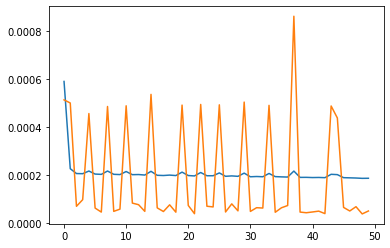

In [96]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
fig.show()

In [97]:
full_dataset.y

tensor([[0.8355],
        [0.8226],
        [0.8997],
        ...,
        [0.8046],
        [0.7815],
        [0.8123]])

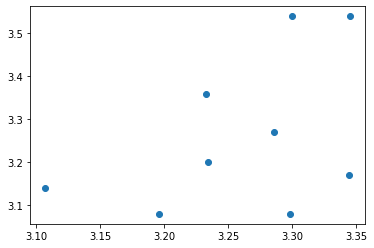

In [98]:
fig = plt.figure()
ax = fig.add_subplot()
# 標準化・正規化を戻す
plot_outputs = ss.inverse_transform(ms.inverse_transform(outputs.cpu().detach().numpy()))
plot_scores = ss.inverse_transform(ms.inverse_transform(scores.cpu().detach().numpy()))
ax.scatter(plot_outputs, plot_scores)
fig.show()

- 重みは更新しない（->p.requires_grad=False）
- 回帰問題にするために、out_features=1に設定
- dataloaderのときにNormalizeを変更、画像サイズも調整 -> h:224, w:224

In [ ]:
class RegressionNet(torch.nn.Module):
    
    def __init__(self):
        super(RegressionNet, self).__init__()
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(32 * 78 * 78, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # x = torch.nn.functional.relu(self.conv1(x))
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])
        x = self.conv1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.pool1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 159, 159])
        # x = torch.nn.functional.relu(self.conv2(x))
        x = self.conv2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.pool2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 78, 78])

        x = x.view(-1, 32 * 78 * 78) # 多次元から1次元に無理やり戻しすぎ
        x = self.relu(x) # 別の活性化関数に変更（tanhなど）
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        print("x:{}".format(x))
        # sigmoid関数を使って0 - 1の値に変換する
        
        return x

In [ ]:
# 1画像1スコアでの出力
arch = "resnet50"
model = models.__dict__[arch](pretrained=True)

# 最後のfc層だけout_features=1に変更
# model.fc = nn.Linear(model.fc.in_features, 1)
# Add Sigmoid
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

for p in model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

# fc層とbiasだけ学習はさせる
model.fc[0].weight.requires_grad=True
model.fc[0].bias.requires_grad=True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model.train()

# data = next(iter(train_loader))
# inputs, labels = data
# labels /= 5
# inputs = inputs.to(device)
# labels = labels.to(device)
# # optimizer.zero_grad()
# outputs = model(inputs)

In [ ]:
# test
model.train()

data = next(iter(train_loader))
img0, img1, img2, scores = data
scores /= 5
img0 = img0.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
scores = scores.to(device)
# optimizer.zero_grad()
outputs = model(img0)